In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from transformers import pipeline

import torch

In [ ]:
classifier = pipeline('sentiment-analysis')
type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
classifier("This is a great movie")

[{'label': 'POSITIVE', 'score': 0.9998798370361328}]

In [ ]:
classifier([
    "This is good",
    "This is bad"
])

[{'label': 'POSITIVE', 'score': 0.9998360872268677},
 {'label': 'NEGATIVE', 'score': 0.9997872710227966}]

In [ ]:
airline_tweets = pd.read_csv("Tweets.csv")
airline_tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = airline_tweets[['airline_sentiment', 'text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabels'

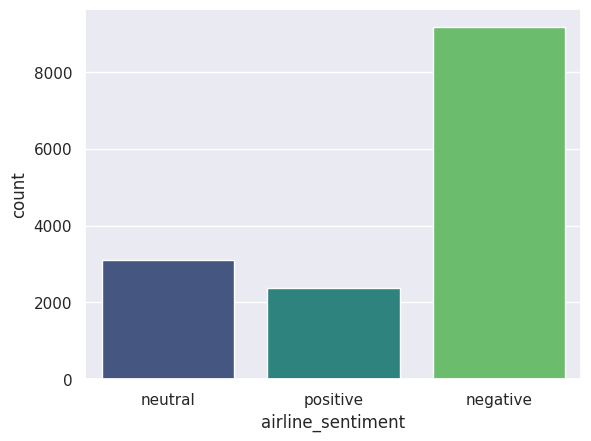

In [ ]:
sns.countplot(df, x='airline_sentiment', palette = 'viridis')
plt.xlabels('Airline sentiment')
plt.ylabels('count')
plt.show()

In [ ]:
df = df[df['airline_sentiment'] != 'neutral']

In [ ]:
df['target'] = df['airline_sentiment'].map({'positive' : 1, 'negative' : 0})

In [ ]:
print('number of rows', df.shape[0])

number of rows 11541


In [ ]:
texts = df['text'].tolist()
predictions = classifier(texts)
predictions[:5]

[{'label': 'POSITIVE', 'score': 0.6070863604545593},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553208947181702}]

In [ ]:
probs = [pred['score'] if pred['label'].startswith('P') else 1 - pred['score'] for pred in predictions]

In [ ]:
preds = np.array([1 if pred['label'].startswith('P') else 0 for pred in predictions])

In [ ]:
print(f"Accuracy: {round(np.mean(df['target'] == preds) *100, 2)} %")

Accuracy: 88.99 %


In [ ]:
cm = confusion_matrix(df['target'], preds, normalize = 'true')

In [ ]:
def plot_confusion_matrix(confusion_matrix, labels):

  plt.figure(figsize = (8, 6))
  sns.set(font_scale = 1.4)

  sns.heatmap(confusion_matrix, annot=True, fmt = 'g', cmap='Blues', xticklabels = labels, yticklabels = labels)

  plt.title("confusion matrix")
  plt.xlabel("predicted")
  plt.ylabel("actual")
  plt.show()

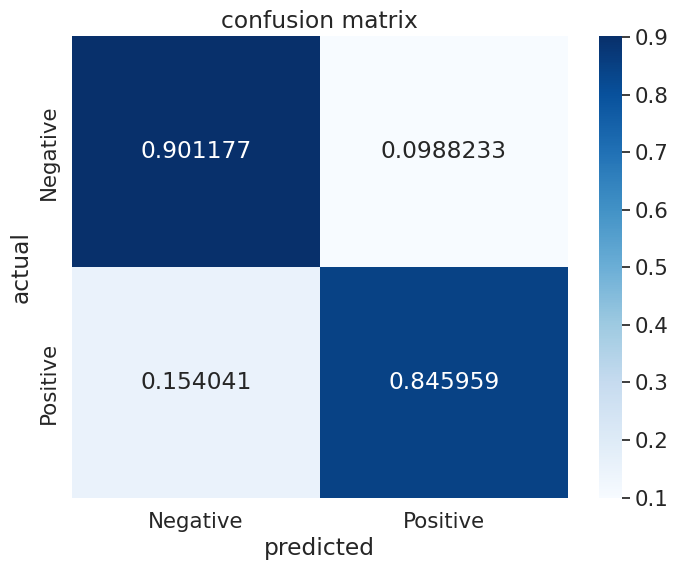

In [ ]:
plot_confusion_matrix(cm, ["Negative", "Positive"])

In [ ]:
print(f"roc auc score:{roc_auc_score(df['target'], probs)}")

roc auc score:0.9485934921195112


In [ ]:
# text generation
poems = pd.read_csv("/content/robert_frost_collection.csv")
poems.head()

,Name,Content,Collection,Year of Publication
0,NaN,NaN,NaN,NaN
1,Stopping by Woods on a Snowy Evening,Whose woods these are I think I know. \nHis ...,New Hampshire,1923.0
2,Fire and Ice,"Some say the world will end in fire,\nSome say...",New Hampshire,1923.0
3,The Aim was Song,Before man came to blow it right\nThe wind onc...,New Hampshire,1923.0
4,The Need of Being Versed in Country Things,The house had gone to bring again\nTo the midn...,New Hampshire,1923.0


In [ ]:
content = poems['Content'].dropna().tolist()

In [ ]:
lines = []
for poem in content:
  for line in poem.split("\n"):
    lines.append(line.rstrip())

In [ ]:
lines = [line for line in lines if len(line) > 0]
lines[:5]

['Whose woods these are I think I know.',
 'His house is in the village though;',
 'He will not see me stopping here',
 'To watch his woods fill up with snow.',
 'My little horse must think it queer']

In [ ]:
gen = pipeline("text-generation")

No model was supplied, defaulted to openai-community/gpt2 and revision 607a30d (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
lines[0]

'Whose woods these are I think I know.'

In [ ]:
gen(lines[0], max_length = 20)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "Whose woods these are I think I know. They're old and I can't even think of"}]

In [ ]:
gen(lines[1], max_length = 30, num_return_sequences = 2)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "His house is in the village though; he never gets into trouble about going there. I've heard him use a car as his lunchbox.\n"},
 {'generated_text': "His house is in the village though; that there isn't much it's worth getting out of one of the houses (at least not yet). I"}]

In [ ]:
import textwrap
def wrap(x):
  return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

In [ ]:
out = gen(lines[0], max_length = 30)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Whose woods these are I think I know.  This, for me, I know, but I'm a
little more worried about things in the area


In [ ]:
prompt = "transformers have a wide variety of applications in nip"
out = gen(prompt, max_length = 100)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


transformers have a wide variety of applications in nip-tuneing and
optimization for web infrastructure.

- Optimized in WebSocket, which
is the TCP protocol that provides data transfer, has seen its adoption
increase in the last few years, due to its better performance.
Optimized in ZMQ, ZMQ-style, it can perform more efficiently than the
standard TCP protocol (see "ZMQ Architecture", "ZMQ-style ZMQ and ZMQ-
style ZMQ").
